# Time Series Forecast: Features &rarr; Emissions (monthly)

### To evaluate:
- Different learning rates
- Different scalers
- Different batch sizes
- Visualize training in tensorboard
- Apply feature selection 

### Import libraries

In [95]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D



### Some useful functions

In [96]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [97]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title = plttitle)
    ax.set(ylabel = metric[0].swapcase() + metric[1:])
    ax.set(xlabel = 'Epoch')
    ax.legend(['train', 'val'], loc = 'upper right')

### Read in input data (features) - X

In [98]:
with open('../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        continue
        #print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input data (features): {feature_data.shape}")

Shape input data (features): (111, 40)


### Read in target data (emissions) - y

In [99]:
emission_data = pd.read_csv('../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')

# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data (emissions): {emission_data.shape}")

Shape output data (emissions): (111,)


### Data preparation

In [100]:
def prepare_data(input_data, output_data, look_back=1, horizon=1, shuffle=False, apply_pca=False, pca_comp=10, scaler = None):
    
    dataX, dataY = [], []
    
    # Check data requirements
    if len(input_data) != len(output_data):
        raise ValueError('Input and ouput do not have same length!')
    
    # Apply PCA to data
    if apply_pca:
        pca = PCA(n_components = pca_comp)
        input_data = pca.fit_transform(input_data)
        print(f"PCA applied on feature input data - New feature input shape: {input_data.shape}")
        
    # Apply scaler to data
    if scaler == None:
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'Standard':
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'MinMax':
        scaler = MinMaxScaler()
        input_data = scaler.fit_transform(input_data)
    else:
        raise ValueError('scaler variable has to be either \'Standard\' or \'MinMax\'!')           
    
    # Apply 'windowing' to data
    for i in range(len(input_data)-look_back-horizon):
        dataX.append(input_data[i:(i+look_back)])
        dataY.append(output_data[(i+look_back):(i+look_back+horizon)])
    
    # Shuffle data
    if shuffle is True:
        random.seed(42)
        dataX, dataY = shuffle(dataX, dataY, random_state=42)
        
    return np.array(dataX), np.array(dataY)

### Define dataset properties

In [101]:
look_back = 12        # months to look back (input data)
horizon = 6           # months to look ahead (target data)
split_ratio = 0.75    # split ratio training / testing 
shuffle = True        # shuffle data yes / no
pca = False           # apply PCA to input data yes / no
scaler = 'Standard'   # choose data scaling method ...
                      # ... either 'Standard' or 'MinMax'

# Split into train and test sets according to split_ratio
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back + horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Define different neural network architectures

### 1D Convolutional Neural Network - CNN (vanilla)

In [102]:
def create_cnn1D(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name='Dense_1'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model

### WaveNet (CNN like Neural Network Architecture)

In [103]:
def create_wavenet(look_back, horizon, plot_summary = False):   
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, X_train.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        
        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        
        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.1)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(3)(out)
    out = GlobalMaxPooling1D()(out)
    #out = Dense(32, activation='relu', name="second_last_dense_layer")(out)
    #out = Dropout(0.1)(out)
    #out = BatchNormalization()(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out, name='WaveNet')
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model 

### Long Short-Term Memory - LSTM

In [104]:
def create_lstm(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()       

    return model

### Create training and test set

In [105]:
X_train, y_train = prepare_data(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
X_test, y_test = prepare_data(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

print("Shape of training data:")
print(f'Training data - X: {X_train.shape}')
print(f'Training data - y: {y_train.shape}')
print()
print("Shape of test data:")
print(f'Test data - X: {X_test.shape}')
print(f'Test data - y: {y_test.shape}')

Shape of training data:
Training data - X: (65, 12, 40)
Training data - y: (65, 6)

Shape of test data:
Test data - X: (10, 12, 40)
Test data - y: (10, 6)


### Create an instance of every neural network architecture

In [106]:
wavenet = create_wavenet(look_back, horizon, plot_summary=False)
cnn1D = create_cnn1D(look_back, horizon, plot_summary=False)
lstm = create_lstm(look_back, horizon, plot_summary=False)

### Train model of every instance and show train history

Train on 52 samples, validate on 13 samples
Epoch 1/25
52/52 [==============================] - 2s 33ms/step - loss: 4736.7409 - r2_keras: -206.1857 - val_loss: 4417.8451 - val_r2_keras: -261.0880
Epoch 2/25
52/52 [==============================] - 0s 4ms/step - loss: 4094.4673 - r2_keras: -179.9529 - val_loss: 3245.8797 - val_r2_keras: -191.2453
Epoch 3/25
52/52 [==============================] - 0s 4ms/step - loss: 2109.1885 - r2_keras: -90.2796 - val_loss: 743.1876 - val_r2_keras: -42.5607
Epoch 4/25
52/52 [==============================] - 0s 3ms/step - loss: 227.1228 - r2_keras: -10.2515 - val_loss: 148.8689 - val_r2_keras: -8.4732
Epoch 5/25
52/52 [==============================] - 0s 4ms/step - loss: 108.1194 - r2_keras: -3.7477 - val_loss: 27.0896 - val_r2_keras: -0.4469
Epoch 6/25
52/52 [==============================] - 0s 4ms/step - loss: 37.8234 - r2_keras: -0.6671 - val_loss: 31.3561 - val_r2_keras: -0.7233
Epoch 7/25
52/52 [==============================] - 0s 3ms/step - 

Epoch 5/25
52/52 [==============================] - 0s 7ms/step - loss: 2039.8466 - r2_keras: -87.2018 - val_loss: 2215.4387 - val_r2_keras: -129.7898
Epoch 6/25
52/52 [==============================] - 0s 9ms/step - loss: 938.4167 - r2_keras: -37.9965 - val_loss: 1128.5032 - val_r2_keras: -65.0775
Epoch 7/25
52/52 [==============================] - 0s 8ms/step - loss: 658.3758 - r2_keras: -27.8202 - val_loss: 889.1084 - val_r2_keras: -51.0838
Epoch 8/25
52/52 [==============================] - 0s 7ms/step - loss: 599.0746 - r2_keras: -24.2714 - val_loss: 768.3315 - val_r2_keras: -44.1386
Epoch 9/25
52/52 [==============================] - 0s 8ms/step - loss: 481.0707 - r2_keras: -19.0517 - val_loss: 655.0253 - val_r2_keras: -37.5599
Epoch 10/25
52/52 [==============================] - 0s 8ms/step - loss: 426.4047 - r2_keras: -22.8724 - val_loss: 851.1014 - val_r2_keras: -49.0668
Epoch 11/25
52/52 [==============================] - 0s 7ms/step - loss: 508.2272 - r2_keras: -18.8207 - va

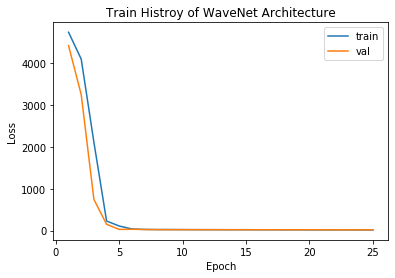

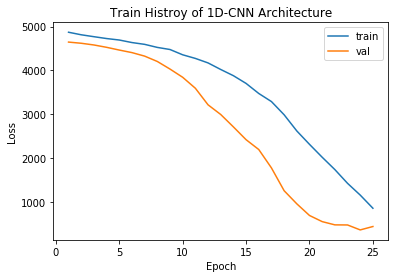

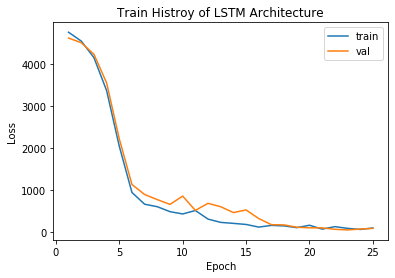

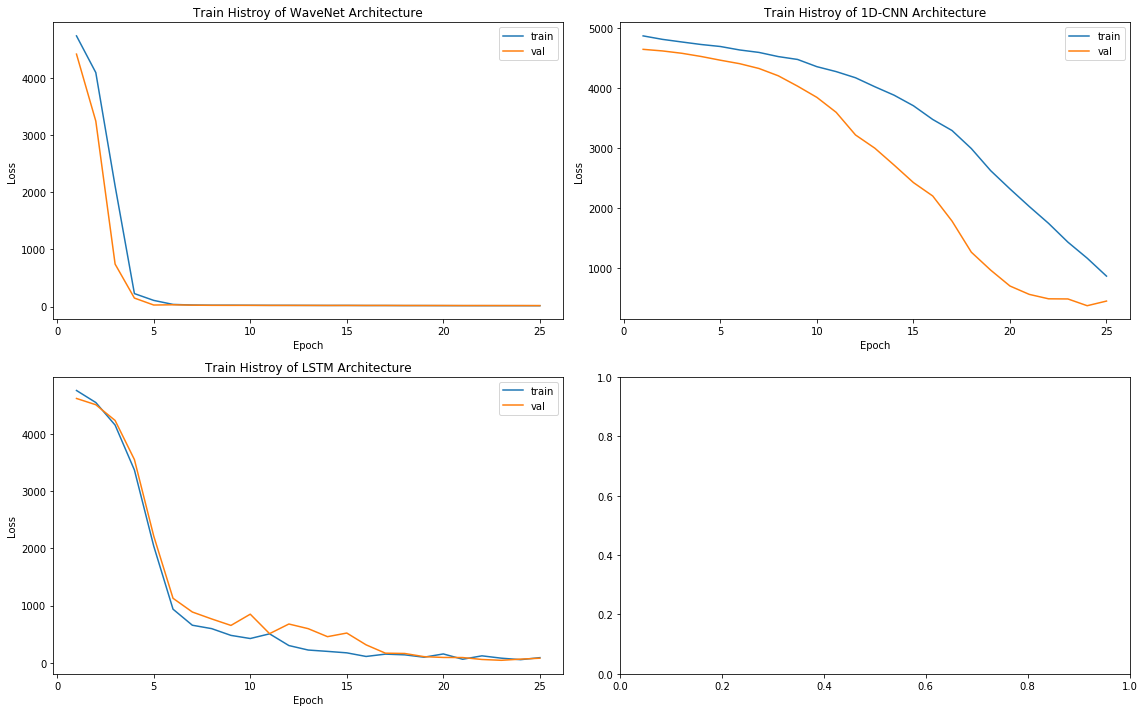

In [107]:
# define callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)

# train models
history_wavenet = wavenet.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_cnn1D = cnn1D.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_lstm = lstm.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])

# plot training history for every model
fig, ax = plt.subplots(2, 2, figsize=(16,10))
plot_model_history(history_wavenet, ax = ax[0,0], plttitle='Train Histroy of WaveNet Architecture')
plot_model_history(history_cnn1D, ax = ax[0,1], plttitle='Train Histroy of 1D-CNN Architecture')
plot_model_history(history_lstm, ax = ax[1,0], plttitle='Train Histroy of LSTM Architecture')
plt.tight_layout()


### Evaluate performance of models

WaveNet Train Score: 564.17 MSE (23.75 RMSE)
WaveNet Test Score: 26.75 MSE (5.17 RMSE)
1D-CNN Train Score: 564.17 MSE (23.75 RMSE)
1D-CNN Test Score: 26.75 MSE (5.17 RMSE)
LSTM Train Score: 564.17 MSE (23.75 RMSE)
LSTM Test Score: 26.75 MSE (5.17 RMSE)


Text(0, 0.5, 'RMSE')

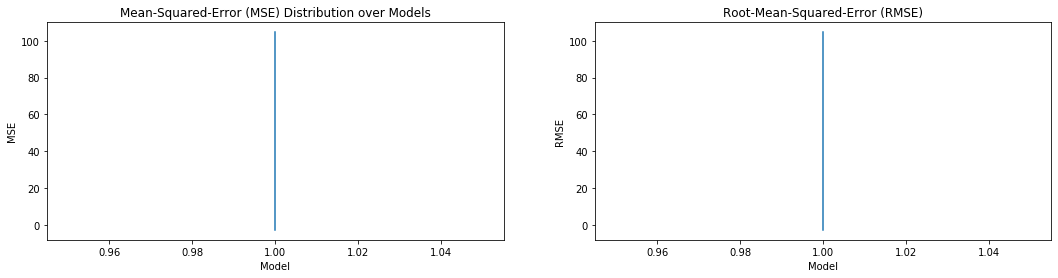

In [112]:
# WaveNet
trainScore_wavenet = wavenet.evaluate(X_train, y_train, verbose=0)
print('WaveNet Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
testScore_wavenet = wavenet.evaluate(X_test, y_test, verbose=0)
print('WaveNet Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# 1D-CNN
trainScore_cnn1D = cnn1D.evaluate(X_train, y_train, verbose=0)
print('1D-CNN Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
testScore_cnn1D = cnn1D.evaluate(X_test, y_test, verbose=0)
print('1D-CNN Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# LSTM
trainScore_lstm = lstm.evaluate(X_train, y_train, verbose=0)
print('LSTM Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
testScore_lstm = lstm.evaluate(X_test, y_test, verbose=0)
print('LSTM Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# Plot Errorbars for MSE & RMSE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))

ax1.errorbar(1, trainScore_lstm)
ax1.set_title('Mean-Squared-Error (MSE) Distribution over Models')
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE')

ax2.errorbar(1, trainScore_lstm)
ax2.set_title('Root-Mean-Squared-Error (RMSE)')
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE')

### Model prediction

In [109]:
# WaveNet
trainPredict_wavenet = wavenet.predict(X_train)
testPredict_wavenet = wavenet.predict(X_test)

# 1D-CNN
trainPredict_cnn1D = cnn1D.predict(X_train)
testPredict_cnn1D = cnn1D.predict(X_test)

# LSTM
trainPredict_lstm = lstm.predict(X_train)
testPredict_lstm = lstm.predict(X_test)

### Plot results

In [110]:
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Shift train predictions for plotting
for t in range(len(trainPredict_wavenet)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict_wavenet[t, :]
for t in range(len(testPredict_wavenet)):
    testPredictPlot[len(trainPredict_wavenet)+t+look_back+horizon:len(trainPredict_wavenet)+
                    t+look_back+(horizon*2)] = testPredict_wavenet[t, :]

Model forecast: [[72.755516 74.37931  73.75861  74.71489  74.761765 74.06808 ]]


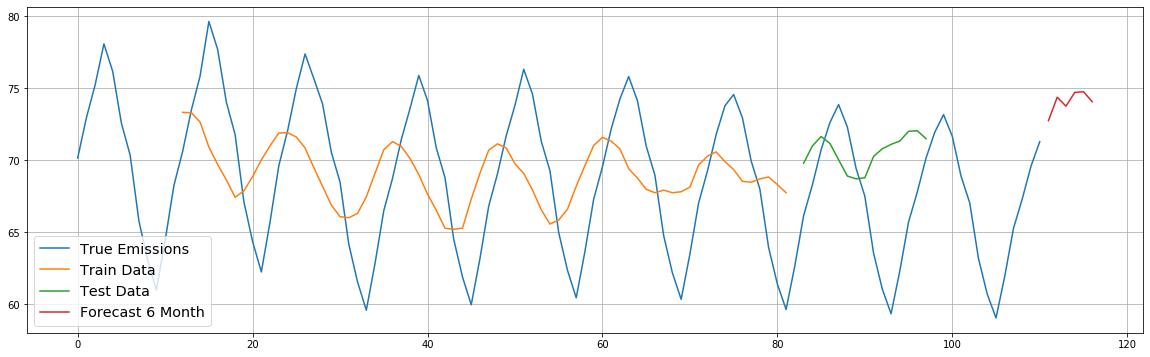

In [111]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, X_train.shape[2]))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :X_train.shape[2]]
predict = wavenet.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Model forecast: {predict}")

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data[:], label='True Emissions')
line2 = plt.plot(trainPredictPlot[:], label='Train Data')
plt.plot(testPredictPlot[:], label='Test Data')
plt.plot(forecastPlot[:], label='Forecast 6 Month')
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()